In [1]:
%matplotlib inline

%reload_ext autoreload
%autoreload 2

In [260]:
from active_learning import ActiveLearner, Oracle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap


# animation
from matplotlib import animation
from celluloid import Camera

# preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

# classification
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

# testing
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

# data
from sklearn.datasets import fetch_20newsgroups

# Ennoncé
Le travail consiste à implémenter un algorithme d’active learning pour la classification de textes selon le pseudo-code
ci-dessous :

Input : ensemble de données étiquetées L, et ensemble de données non étiquetées U

Output : ensemble de données étiquetées L UNION U

Tant que U non vide
1. Entraîner un classifieur C (par exemple, un simple classifieur bayesien naif) en utilisant L
2. Utiliser C pour prédire les données U
3. Sélectionner dans U n instances et former un ensemble I contenant ces instances
4. Demander à l’expert d’étiqueter I
5. Faire L = L UNION I et U = U MOINS I
L’expert devra être simulé par le programme.

La technique de sélection utilisée au point 3 sera l'Uncertainty Sampling.
On utilisera les algorithmes de classification implémentés dans Scikit.

A chaque étape on affichera une métrique d’évaluation (utilisant les implémentation de Scikit).
Les données à utiliser sont :

le sous-ensemble NG5 du corpus NG20 accessible via Scikit.

NG5 comprend les classes :
'rec.motorcycles',
'rec.sport.baseball',
'comp.graphics',
'sci.space',
'talk.politics.mideast'

Le corpus Classic3 accessible à l’adresse :
https://mycloud.mi.parisdescartes.fr/s/HwpG4bmaRp3sSCC
ATTENTION : pour NG5, on utilisera l’option remove=('headers', 'footers', 'quotes') pour une évaluation plus réaliste

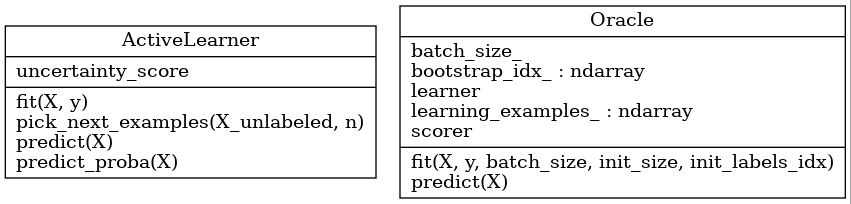

In [3]:
def anim_to_html(anim):
    plt.close(anim._fig)
    return anim.to_html5_video()

animation.Animation._repr_html_ = anim_to_html

In [154]:
def draw_choice(X, y, choice_order, ax, i, first=0):
    chosen = choice_order == i
    if i < 0:
        chosen = choice_order < 0
    
    choice = np.repeat('yes', chosen.shape[0])
    choice = choice.astype('<U10')
    choice[choice_order > i] = 'no'
    choice[choice_order < 0] = 'initial'
    
    

    
    pt_size = np.repeat('old', chosen.shape[0])
    pt_size[chosen] = 'new'
    pt_size = pd.Series(pt_size, name='selection time')
    
    choice = pd.Series(choice, name='chosen')
    target = pd.Series(y, name='class')
    
    sns.scatterplot(X[:,0], X[:,1],
                    ax=ax,
                    hue=target, palette='tab10',
                    size=pt_size,
                    size_order = ['new', 'old'],
                    sizes=(40, 80),
                    style=choice,
                    markers={'yes': 'o', 'no': 'X', 'initial': 's'},
                    legend='full' if i==first else None)
    if i == first:
        ax.legend(loc='center left', 
                  bbox_to_anchor=(1.01,.5))

In [140]:
def animate_choices(X, y, choice_order, interval=200, first=0):
    fig = plt.figure(figsize=(10,5))
    
    # to avoid the legend being clipped
    ax = fig.add_axes([0.1, 0.1, 0.6, 0.9]) # [left, bottom, width, height]
    
    camera = Camera(fig)
    chosen = np.zeros(choice_order.shape, dtype=bool)
    for it in range(-5, choice_order.max()+5):
        draw_choice(X, y, choice_order, ax, it, first=first)
        camera.snap()
    
    return camera.animate(interval=interval)

In [262]:
def add_model_boundaries(ax, model):
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()

    npts = 1000
    hx = (x_max - x_min)/npts
    hy = (y_max - y_min)/npts

    xx, yy = np.meshgrid(np.arange(x_min, x_max, hx),
                         np.arange(y_min, y_max, hy))
    
    #########################
    
    # get colormap
#     ncolors = 256
#     color_array = plt.get_cmap('tab10')(range(ncolors))

    # change alpha values
#     color_array[:,-1] = np.linspace(0.4,0.0,ncolors)

    # create a colormap object
#     cm = LinearSegmentedColormap.from_list(name='rainbow_alpha',colors=color_array)
    
    #########################
    
    cm = plt.cm.tab10
#     cm = plt.cm.nipy_spectral
    x = xx.ravel()
    y = yy.ravel()

    grid = np.c_[x, y]
    Z = model.predict(grid)
    Z = Z.reshape(xx.shape)
#     probs = model.predict_proba(grid).max(axis=1)
    probs = model.uncertainty_scorer(grid)
    probs = probs.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.4) #*probs
    return ax


def draw_choice(X, y, choice_order, ax, i, model, first=0):
    chosen = choice_order == i
    if i < 0:
        chosen = choice_order < 0
    
    choice = np.repeat('yes', chosen.shape[0])
    choice = choice.astype('<U10')
    choice[choice_order > i] = 'no'
    choice[choice_order < 0] = 'initial'
    
    pt_size = np.repeat('old', chosen.shape[0])
    pt_size[chosen] = 'new'
    pt_size = pd.Series(pt_size, name='selection time')
    
    choice = pd.Series(choice, name='chosen')
    target = pd.Series(y, name='class')
       
    ax = sns.scatterplot(X[:,0], X[:,1],
                    ax=ax,
                    hue=target, palette='tab10',
                    size=pt_size,
                    size_order = ['new', 'old'],
                    sizes=(40, 80),
                    style=choice,
                    markers={'yes': 'o', 'no': 'X', 'initial': 's'},
                    legend='full' if i==first else None)
    
    if model is not None:
        add_model_boundaries(ax, model)
    
    if i == first:
        ax.legend(loc='center left', 
                  bbox_to_anchor=(1.01,.5))
    return ax

In [241]:
def animate_choices(X, y, choice_order, models, interval=200, first=0):
    fig = plt.figure(figsize=(10,5))
    
    # to avoid the legend being clipped
    ax = fig.add_axes([0.1, 0.1, 0.6, 0.9]) # [left, bottom, width, height]
    
    camera = Camera(fig)
    chosen = np.zeros(choice_order.shape, dtype=bool)
    for it in range(-5, choice_order.max()+5):
        idx = min(it, len(models)-1)
        model = None if idx < 0 else models[idx]
        draw_choice(X, y, choice_order, ax, it, model, first=first)
        camera.snap()
    
    return camera.animate(interval=interval)

## Utilisation de données simples

In [198]:
sample = pd.read_csv('./sample_data/Aggregation.txt', sep='\t', header=None, names=['x1','x2','y'])
sample.head()

,x1,x2,y
0,15.55,28.65,2
1,14.90,27.55,2
2,14.45,28.35,2
3,14.15,28.80,2
4,13.75,28.05,2


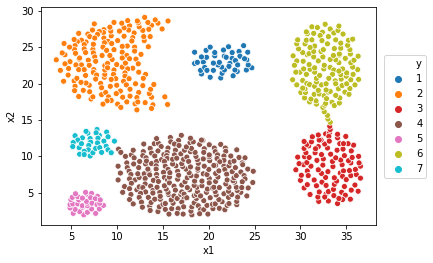

In [199]:
ax = sns.scatterplot(sample.x1, sample.x2,
                hue=sample.y, palette='tab10',
                legend='full')
ax.legend(loc='center left', bbox_to_anchor=(1.01,.5))

In [200]:
X = sample[['x1', 'x2']].values
y = sample.y.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, stratify=y)

In [230]:
classifier = LogisticRegression
clf_params = dict(solver='lbfgs', multi_class='auto', max_iter=100)
batch_size = 40
init_size = 40

In [231]:
lc_learner = ActiveLearner(classifier(**clf_params), strategy='least_conf')
lc_oracle = Oracle(lc_learner, metrics=[precision_score, recall_score, f1_score])
lc_oracle.fit(X_train, y_train, X_test, y_test, batch_size=batch_size, init_size=init_size)

/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model

In [245]:
init_idx = lc_oracle.time_chosen_ == -1

In [246]:
margin_learner = ActiveLearner(classifier(**clf_params), strategy='margin')
margin_oracle = Oracle(margin_learner, metrics=[precision_score, recall_score, f1_score])
margin_oracle.fit(X_train, y_train, X_test, y_test, batch_size=batch_size, init_labels_idx=init_idx)

/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model

In [247]:
entropy_learner = ActiveLearner(classifier(**clf_params), strategy='entropy')
entropy_oracle = Oracle(entropy_learner, metrics=[precision_score, recall_score, f1_score])
entropy_oracle.fit(X_train, y_train, X_test, y_test, batch_size=batch_size, init_labels_idx=init_idx)

/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model

In [248]:
rand_learner = ActiveLearner(classifier(**clf_params), strategy='random')
rand_oracle = Oracle(rand_learner, metrics=[precision_score, recall_score, f1_score])
rand_oracle.fit(X_train, y_train, X_test, y_test, batch_size=batch_size, init_labels_idx=init_idx)

/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model

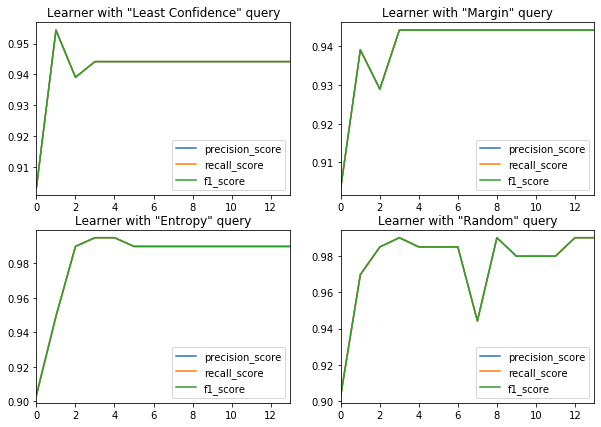

In [249]:
fig = plt.figure(figsize=(10,7))
ax = plt.subplot(221)
lc_oracle.performance_scores_.plot(ax=ax)
ax.set_title('Learner with "Least Confidence" query')
ax = plt.subplot(222)
margin_oracle.performance_scores_.plot(ax=ax)
ax.set_title('Learner with "Margin" query')
ax = plt.subplot(223)
entropy_oracle.performance_scores_.plot(ax=ax)
ax.set_title('Learner with "Entropy" query')
ax = plt.subplot(224)
rand_oracle.performance_scores_.plot(ax=ax)
ax.set_title('Learner with "Random" query');

In [263]:
choice_order = lc_oracle.time_chosen_.copy()
models = lc_oracle.models_
# choice_order[choice_order >= 0] = choice_order[choice_order >= 0] // 5 # reduce the number of frames
anim = animate_choices(X_train, y_train, choice_order, models, interval=500)
anim

In [250]:
choice_order = margin_oracle.time_chosen_.copy()
models = margin_oracle.models_
# choice_order[choice_order >= 0] = choice_order[choice_order >= 0] // 5 # reduce the number of frames
anim = animate_choices(X_train, y_train, choice_order, models, interval=500)
anim

In [225]:
choice_order = entropy_oracle.time_chosen_.copy()
models = entropy_oracle.models_
# choice_order[choice_order >= 0] = choice_order[choice_order >= 0] // 5 # reduce the number of frames
anim = animate_choices(X_train, y_train, choice_order, models, interval=500)
anim

In [227]:
choice_order = rand_oracle.time_chosen_.copy()
models = rand_oracle.models_
# choice_order[choice_order != -1] = choice_order[choice_order != -1] // 5 # reduce the number of frames
anim = animate_choices(X_train, y_train, choice_order, models, interval=500)
anim

In [118]:
def plot_choice_order(time_chosen, y):
    choice_order = np.argsort(time_chosen)
    y = y[choice_order]
    labels = np.unique(y)
    classes = np.arange(labels.shape[0])
    class_mat = np.zeros((y.shape[0], classes.shape[0]), dtype=bool)
    for c in classes:
        class_mat[:, c] = y == labels[c]

    class_counts = class_mat.sum(axis=0)
    df_classes = pd.DataFrame(class_mat, columns=labels)

    percent_chosen = df_classes.cumsum(axis=0)/class_counts
    ax = percent_chosen.plot(cmap='tab10')
    return ax

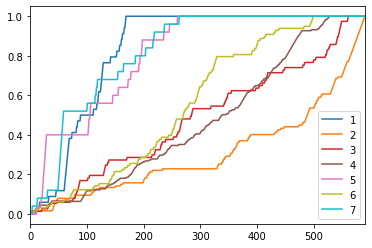

In [124]:
plot_choice_order(lc_oracle.time_chosen_, y_train)
ax.set_title('Percentage of examples chosen for each class');

## Données NG5

In [92]:
categories = ['rec.motorcycles', 'rec.sport.baseball',
                'comp.graphics', 'sci.space',
                'talk.politics.mideast']
remove = ("headers", "footers", "quotes")
ng5_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
ng5_test = fetch_20newsgroups(subset='test', categories=categories, remove=remove)

X_train, y_train = ng5_train.data, np.array(ng5_train.target)
X_test, y_test = ng5_test.data, np.array(ng5_test.target)

In [93]:
tfidf = TfidfVectorizer().fit(X_train)
X_train = tfidf.transform(X_train)
X_test = tfidf.transform(X_test)

In [97]:
# clf = make_pipeline(TfidfVectorizer(), GaussianNB())
clf = GaussianNB()
learner = ActiveLearner(clf)
oracle = Oracle(learner, metrics=[precision_score, recall_score, f1_score])

In [99]:
oracle.fit(X_train.toarray(), y_train, X_test.toarray(), y_test, batch_size=100, init_size=200)

Text(0.5, 1, 'Learner with "Least Confidence" query')

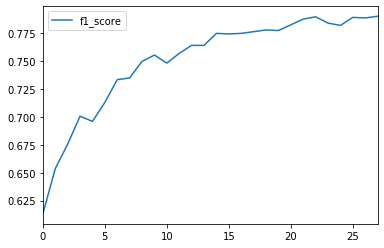

In [100]:
oracle.performance_scores_.plot()
# ax.set_title('Learner with "Least Confidence" query')
# ax = plt.subplot(222)
# margin_oracle.performance_scores_.plot(ax=ax)
# ax.set_title('Learner with "Margin" query')
# ax = plt.subplot(223)
# entropy_oracle.performance_scores_.plot(ax=ax)
# ax.set_title('Learner with "Entropy" query')
# ax = plt.subplot(224)
# rand_oracle.performance_scores_.plot(ax=ax)
# ax.set_title('Learner with "Random" query');

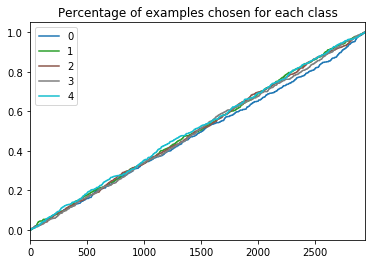

In [109]:
plot_choice_order(oracle.time_chosen_, y_train)